<a href="https://colab.research.google.com/github/Adachi-Yoshitaka/clustering/blob/main/%E7%94%BB%E5%83%8F%E3%81%AE%E3%82%AF%E3%83%A9%E3%82%B9%E3%82%BF%E3%83%AA%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone --recursive https://github.com/Adachi-Yoshitaka/clustering

Cloning into 'clustering'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 222 (delta 21), reused 68 (delta 0), pack-reused 115
Receiving objects: 100% (222/222), 15.07 MiB | 26.51 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [2]:
%cd /content/clustering

/content/clustering


In [3]:
from PIL import Image, ImageDraw
from numpy import *
from pylab import *
import scipy.misc
from scipy.cluster.vq import *
import imtools
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import os
import hcluster
import sift

#演習問題6.4.1

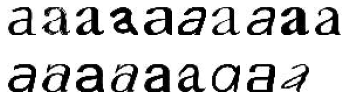

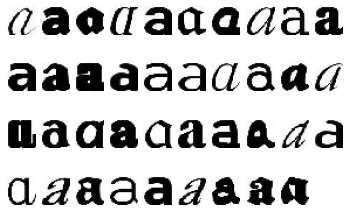

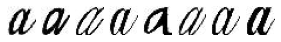

In [ ]:
imlist = imtools.get_imlist('selected_fontimages/')
imnbr = len(imlist)
with open('font_pca_modes.pkl', 'rb') as f:
    immean = pickle.load(f)
    V = pickle.load(f)
immatrix = array([array(Image.open(im)).flatten() for im in imlist], 'f')
immean = immean.flatten()
projected = array([dot(V[:40], immatrix[i]-immean) for i in range(imnbr)])
cluster_num = 3
projected = whiten(projected)
centroids, distortion = kmeans(projected, cluster_num)
code, distance = vq(projected, centroids)
for k in range(cluster_num):
    ind = where(code==k)[0]
    figure()
    gray()
    for i in range(minimum(len(ind), 40)):
        subplot(4, 10, i+1)
        imshow(immatrix[ind[i]].reshape((25, 25)))
        axis('off')
show()

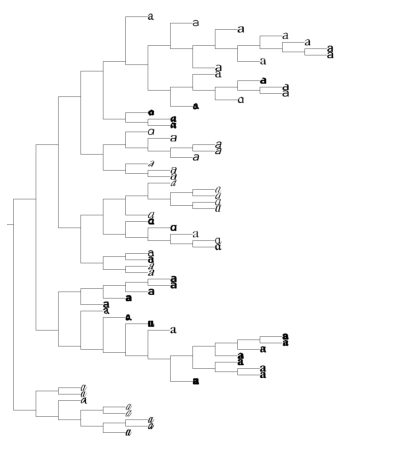

In [ ]:
#ブランチを作る関数
def divide_branch(data, branch, k):
    div = min(k, len(branch))
    if div<=1:
        return list(branch)
    centroids, distortion = kmeans(data[branch], k)
    code, distance = vq(data[branch], centroids)
    new_branch = []
    for i in range(k):
        ind = where(code==i)[0]
        if len(ind)==0:
            continue
        else:
            new_branch.append(divide_branch(data, branch[ind], k))
    return new_branch

#k=4で階層型k平均法を実行
tree = array([i for i in range(projected.shape[0])])
branches = divide_branch(projected, tree,k)

#以下は描画のため
def get_depth(t):
    if len(t)<2:
        return 1
    else:
        return max([get_depth(tt) for tt in t])+1

def get_height(t):
    if (len(t)<2):
        return 1
    else:
        return sum([get_height(tt) for tt in t])

#ノードを描画する関数
def draw_node(node, draw, x, y, s, iml, im):
    if len(node)<1:
        return
    if len(node)==1:
        nodeim = Image.open(iml[node[0]])
        nodeim.thumbnail([20, 20])
        ns = nodeim.size
        im.paste(nodeim, [int(x), int(y-ns[1]//2), int(x+ns[0]), int(y+ns[1]-ns[1]//2)])
    else:
        ht = sum([get_height(n) for n in node])*20/2
        h1 = get_height(node[0])*20/2
        h2 = get_height(node[-1])*20/2
        top = y-ht
        bottom = y+ht
        draw.line((x, top+h1, x, bottom-h2), fill=(0, 0, 0))
        ll = 1*s
        y = top
        for i in range(len(node)):
            y += get_height(node[i])*20/2
            draw.line((x, y, x+ll, y), fill=(0, 0, 0))
            draw_node(node[i], draw, x+ll, y, s, imlist, im)
            y += get_height(node[i])*20/2

#ツリーを描画
def draw_dendrogram(node, iml, filename='kclusters.jpg'):
    rows = get_height(node)*20+40
    cols = 1200

    s = float(cols-150)/get_depth(node)

    im =  Image.new('RGB', (cols, rows), (255, 255, 255))
    draw = ImageDraw.Draw(im)

    draw.line((0, rows/2, 20, rows/2), fill=(0, 0, 0))
    draw_node(node, draw, 20, (rows/2), s, iml, im)
    im.save(filename)
    plt.figure(figsize=(8,8))
    plt.imshow(np.array(im))
    plt.axis('off')
    plt.show()

#ツリーを出力
draw_dendrogram(branches, imlist, filename='k_fonts.jpg')

#演習問題6.4.2

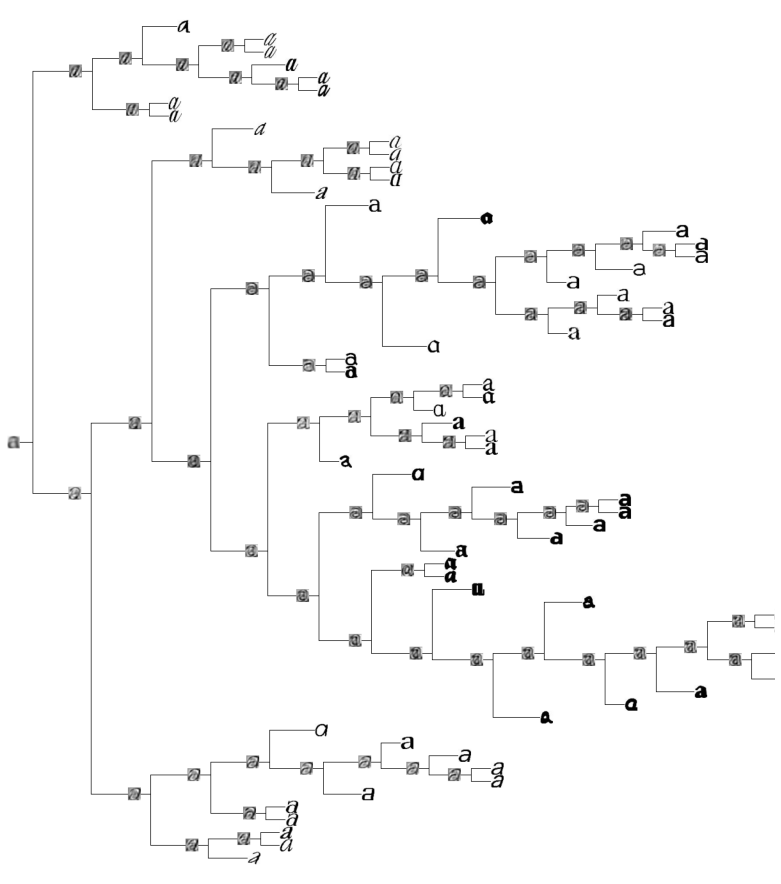

In [ ]:
def divide_branch_with_center(data, branch, k):
    div = min(k, len(branch))
    if div<=1:
        return list(branch)
    centroids, distortion = kmeans(data[branch], k)
    code, distance = vq(data[branch], centroids)
    new_branch = []
    for i in range(k):
        ind = where(code==i)[0]
        if len(ind)==0:
            continue
        else:
            new_branch.append((centroids[i], distance[i], divide_branch_with_center(data, branch[ind], k)))
    return new_branch

#ツリーの作成
tree = array([i for i in range(projected.shape[0])])
branches = ([0 for i in range(40)], 0, divide_branch_with_center(projected, tree, k))

#以下はツリーの描画用
def get_depth(t):
    if len(t[2])<2:
        return 1
    else:
        return max([get_depth(tt) for tt in t[2]])+1

def get_height(t):
    if (len(t[2])<2):
        return 1
    else:
        return sum([get_height(tt) for tt in t[2]])

def draw_average(center, x, y, im):
    c = center/np.linalg.norm(center)
    avim = dot((V[:40]).T, c)
    avim = 255*(avim-min(avim))/(max(avim)-min(avim)+1e-6)
    avim = avim.reshape(25, 25)
    avim[avim<0] = 0
    avim[avim>255] = 255
    avim = Image.fromarray(avim)
    avim.thumbnail([20, 20])
    ns = avim.size
    im.paste(avim, [int(x), int(y-ns[1]//2), int(x+ns[0]), int(y+ns[1]-ns[1]//2)])

def draw_node(node, draw, x, y, s, iml, im):
    if len(node[2])<1:
        return
    if len(node[2])==1:
        nodeim = Image.open(iml[node[2][0]])
        nodeim.thumbnail([20, 20])
        ns = nodeim.size
        im.paste(nodeim, [int(x), int(y-ns[1]//2), int(x+ns[0]), int(y+ns[1]-ns[1]//2)])
    else:
        ht = sum([get_height(n) for n in node[2]])*20/2
        h1 = get_height(node[2][0])*20/2
        h2 = get_height(node[2][-1])*20/2
        top = y-ht
        bottom = y+ht
        draw.line((x, top+h1, x, bottom-h2), fill=(0, 0, 0))
        y = top
        for i in range(len(node[2])):
            ll = node[2][i][1]/8*s
            y += get_height(node[2][i])*20/2
            xx = x + ll + s/4
            draw.line((x, y, xx, y), fill=(0, 0, 0))
            if len(node[2][i][2])>1:
                draw_average(node[2][i][0], xx, y, im)
                xx = xx+20
            draw.line((xx, y, xx+s/4, y), fill=(0, 0, 0))
            xx = xx+s/4
            draw_node(node[2][i], draw, xx, y, s, imlist, im)
            y += get_height(node[2][i])*20/2

def draw_dendrogram(node, iml, filename='kclusters.jpg'):
    rows = get_height(node)*20+40
    cols = 1200

    s = float(cols-150)/get_depth(node)

    im =  Image.new('RGB', (cols, rows), (255, 255, 255))
    draw = ImageDraw.Draw(im)

    x = 0
    y = rows/2
    avim = Image.fromarray(immean.reshape(25, 25))
    avim.thumbnail([20, 20])
    ns = avim.size
    im.paste(avim, [int(x), int(y-ns[1]//2), int(x+ns[0]), int(y+ns[1]-ns[1]//2)])
    draw.line((x+20, y, x+40, y), fill=(0, 0, 0))
    draw_node(node, draw, x+40, (rows/2), s, iml, im)
    im.save(filename)
    plt.figure(figsize=(16,16))
    plt.imshow(np.array(im))
    plt.axis('off')
    plt.show()

draw_dendrogram(branches, imlist, filename='k_fonts.jpg')

#演習問題6.4.3

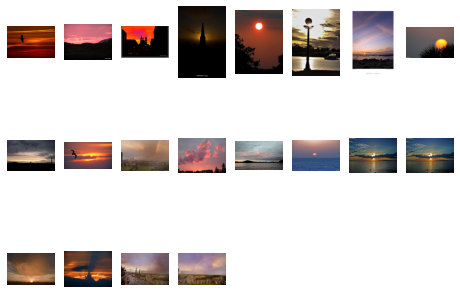

In [36]:
path = 'flickr-sunsets-small/'
imlist = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]
features = zeros([len(imlist), 512])
for i, f in enumerate(imlist):
    im = array(Image.open(f))

    h, edges = histogramdd(im.reshape(-1, 3), 8, normed=True, range=[(0,255), (0, 255), (0, 255)])

    features[i] = h.flatten()
tree = hcluster.hcluster(features)

#新しい関数を実行して８個以下のクラスターを取得
clusters = tree.extract_clusters_by_num(8)

for c in clusters:
    elements = c.get_cluster_elements()
    nbr_elements = len(elements)
    if nbr_elements>3:
        figure(figsize=(8, 8))
        for p in range(minimum(nbr_elements, 20)):
            subplot(4, 8, p+1)
            im = array(Image.open(imlist[elements[p]]))
            imshow(im)
            axis('off')
show()

#演習問題6.4.4

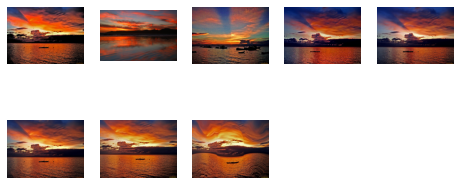

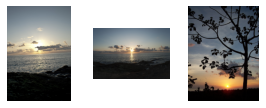

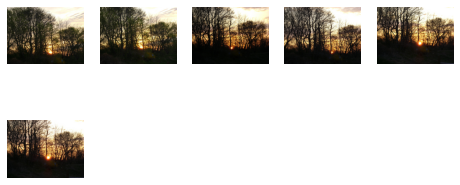

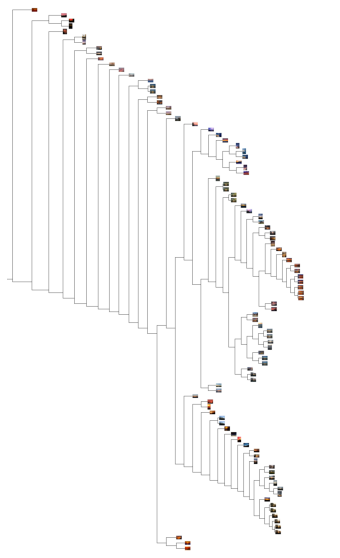

In [39]:
path = 'flickr-sunsets-small/'
imlist = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]

features = zeros([len(imlist), 512])
for i, f in enumerate(imlist):
    im = array(Image.open(f))

    h, edges = histogramdd(im.reshape(-1, 3), 8, normed=True, range=[(0,255), (0, 255), (0, 255)])

    features[i] = h.flatten()

#以下通常の平均リンク
tree = hcluster.hcluster(features, hcluster.L2dist)
clusters = tree.extract_clusters(0.24*tree.distance)

for c in clusters:
    elements = c.get_cluster_elements()
    nbr_elements = len(elements)
    if nbr_elements>2:
        figure(figsize=(8, 8))
        for p in range(minimum(nbr_elements, 20)):
            subplot(4, 5, p+1)
            im = array(Image.open(imlist[elements[p]]))
            imshow(im)
            axis('off')
show()
hcluster.draw_dendrogram(tree, imlist, filename='alamo_average.pdf')

In [ ]:
#単リンク法
#バカほど時間かかる、二度と回さん
tree = hcluster.hcluster(features, hcluster.L2dist_single)
clusters = tree.extract_clusters(0.24*tree.distance)

for c in clusters:
    elements = c.get_cluster_elements()
    nbr_elements = len(elements)
    if nbr_elements>2:
        figure(figsize=(8, 8))
        for p in range(minimum(nbr_elements, 20)):
            subplot(4, 5, p+1)
            im = array(Image.open(imlist[elements[p]]))
            imshow(im)
            axis('off')
show()
hcluster.draw_dendrogram(tree, imlist, filename='alamo_single.pdf')

In [ ]:
#完全リンク法
#バカほど時間かかる、二度と回さん
tree = hcluster.hcluster(features, hcluster.L2dist_complete)
clusters = tree.extract_clusters(0.24*tree.distance)

for c in clusters:
    elements = c.get_cluster_elements()
    nbr_elements = len(elements)
    if nbr_elements>2:
        figure(figsize=(8, 8))
        for p in range(minimum(nbr_elements, 20)):
            subplot(4, 5, p+1)
            im = array(Image.open(imlist[elements[p]]))
            imshow(im)
            axis('off')
show()
hcluster.draw_dendrogram(tree, imlist, filename='alamo_complete.pdf')

#演習問題6.4.5

In [ ]:
imlist = imtools.get_imlist('flickr-sunsets-small/')
nbr_images = len(imlist)
matchscores = zeros((nbr_images, nbr_images))
featlist = []
for imname in imlist:
    #name, ext = os.path.splitext(imname)
    name = os.path.splitext(os.path.basename(imname))[0]
    featname = name+'.sift'
    sift.process_image(imname, featname)
    sift.write_features_to_file(featname)
    featlist.append(featname)

cnt = 0
for i in range(nbr_images):
    for j in range(i, nbr_images):
        cnt += 1
        print(cnt, "/ ", (nbr_images+1)*nbr_images/2)
        print('comparing', imlist[i], imlist[j])

        try:
            l1, d1 = sift.read_features_from_file(featlist[i])
            l2, d2 = sift.read_features_from_file(featlist[j])
            matches = sift.match_twosided(d1, d2)
        except(IndexError):
            matches = []

        nbr_matches = sum(matches)
        print('number of matches = ', nbr_matches)
        matchscores[i, j] = nbr_matches

for i in range(nbr_images):
    for j in range(i+1, nbr_images):
        matchscores[j, i] = matchscores[i, j]

print(matchscores)

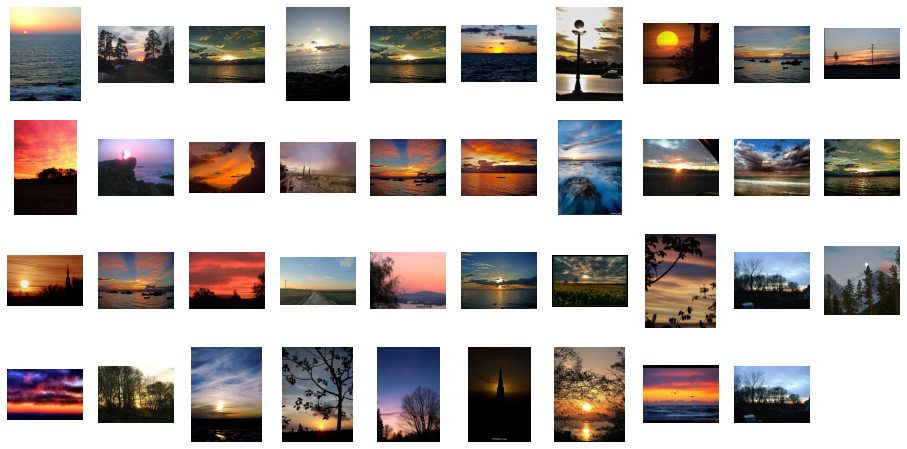

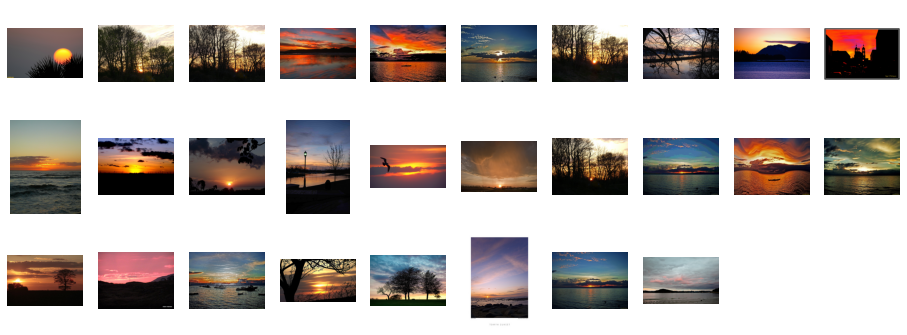

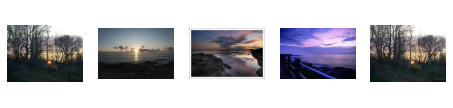

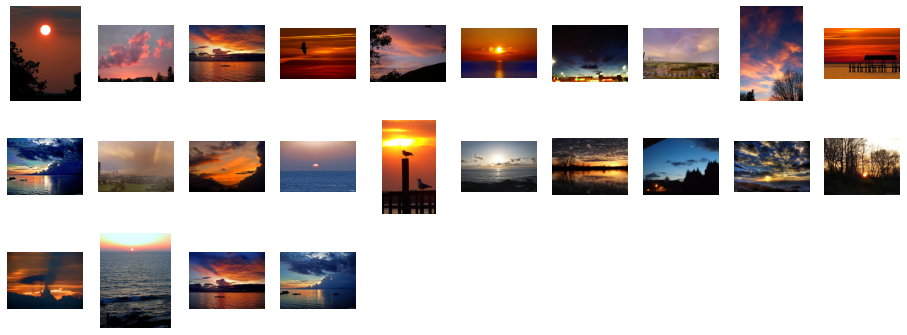

In [18]:
#まずは通常のラプラシアンで
n = len(imlist)
S = 1/(matchscores+1e-6)

rowsum = sum(S, axis=0)
D = diag(1/sqrt(rowsum))
I = identity(n)
L = I - dot(D, dot(S, D))
U, sigma, V = linalg.svd(L)

k = 4
features = array(V[:k]).T
features = whiten(features)
centroids, distortion = kmeans(features, k)
code, distance = vq(features, centroids)

for c in range(k):
    ind = where(code==c)[0]
    figure(figsize=(16, 8))
    for i in range(minimum(len(ind), 39)):
        im = Image.open(imlist[ind[i]])
        subplot(4, 10, i+1)
        gray()
        imshow(array(im))
        axis('equal')
        axis('off')
show()

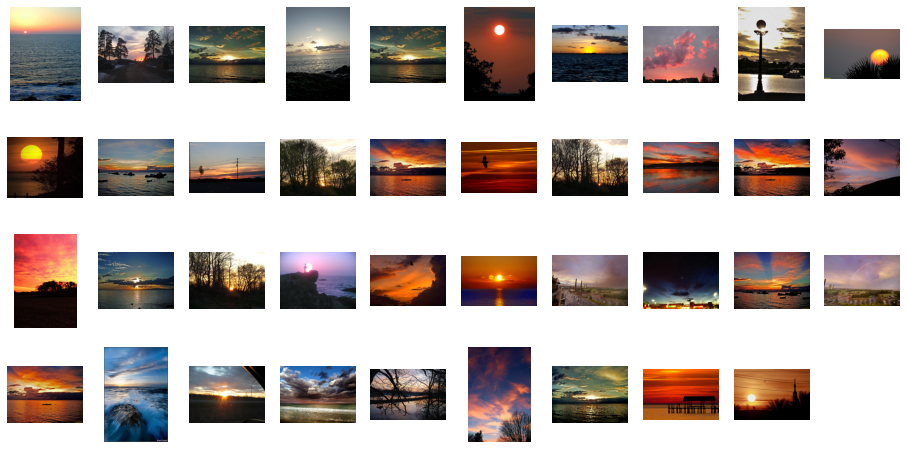

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [20]:
#次にD^-1Sによるもの
n = len(imlist)
S = 1/(matchscores+1e-6)
rowsum = sum(S, axis=0)
D = diag(1/rowsum)
I = identity(n)
L = dot(D, S)
U, sigma, V = linalg.svd(L)
k = 4
features = array(V[:k]).T
features = whiten(features)
centroids, distortion = kmeans(features, k)
code, distance = vq(features, centroids)

for c in range(k):
    ind = where(code==c)[0]
    figure(figsize=(16, 8))
    for i in range(minimum(len(ind), 39)):
        im = Image.open(imlist[ind[i]])
        subplot(4, 10, i+1)
        gray()
        imshow(array(im))
        axis('equal')
        axis('off')
show()

#演習問題6.4.6

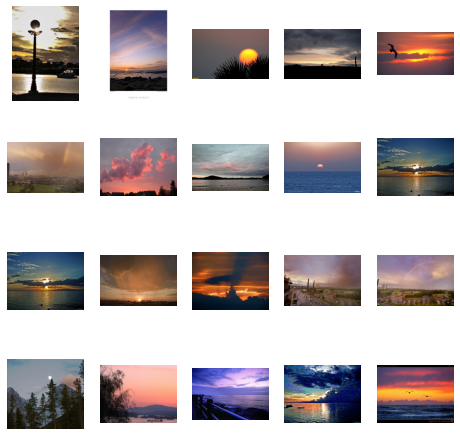

In [21]:
path = 'flickr-sunsets-small/'
imlist = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]

#sunsetと同じように
features = zeros([len(imlist), 512])
for i, f in enumerate(imlist):
    im = array(Image.open(f))

    h, edges = histogramdd(im.reshape(-1, 3), 8, normed=True, range=[(0,255), (0, 255), (0, 255)])

    features[i] = h.flatten()

tree = hcluster.hcluster(features)
clusters = tree.extract_clusters(0.6*tree.distance)

for c in clusters:
    elements = c.get_cluster_elements()
    nbr_elements = len(elements)
    if nbr_elements>3:
        figure(figsize=(8, 8))
        for p in range(minimum(nbr_elements, 20)):
            subplot(4, 5, p+1)
            im = array(Image.open(imlist[elements[p]]))
            imshow(im)
            axis('off')
show()

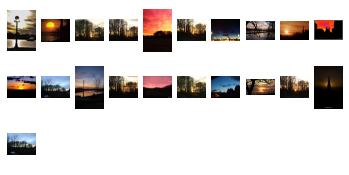

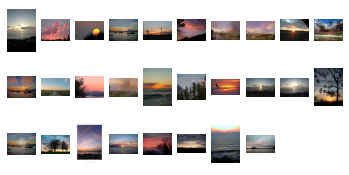

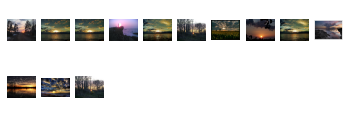

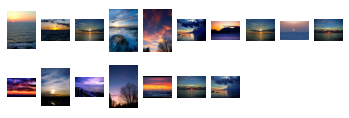

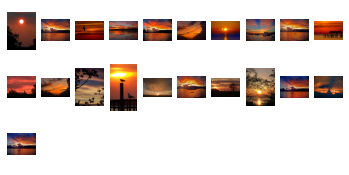

In [22]:
#スペクトラルクラスタリングを適用してみる
n = len(features)
S = array([[sqrt(sum((features[i]-features[j])**2)) for i in range(n)] for j in range(n)], 'f')
rowsum = sum(S, axis=0)
D = diag(1/sqrt(rowsum))
I = identity(n)
L = I - dot(D, dot(S, D))
U, sigma, V = linalg.svd(L)

k = 5
f = array(V[:k]).T
f = whiten(f)
centroids, distortion = kmeans(f, k)
code, distance = vq(f, centroids)

#結果の描画
for c in range(k):
    ind = where(code==c)[0]
    figure()
    for i in range(minimum(len(ind), 39)):
        im = Image.open(imlist[ind[i]])
        subplot(4, 10, i+1)
        gray()
        imshow(array(im))
        axis('equal')
        axis('off')
show()